# High-Resolution Spectroscopy

This tutorial demonstrates how to use POSEIDON's forward model, TRIDENT, to generate grids of high spectral resolution models. We'll assume familiarity with the main functions covered in [\"Generating Transmission Spectra with TRIDENT\"](transmission_basic.html).

As a case study, here we consider WASP-76b — a hot Jupiter with many recent chemical species detections at high-resolution.   

First, we define the main star and planet properties for the WASP-76 system (the values below are from [exo.MAST](https://exo.mast.stsci.edu/)).

In [1]:
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_Sun, R_J
import numpy as np

#***** Define stellar properties *****#

R_s = 1.73*R_Sun      # Stellar radius (m)
T_s = 6250.0          # Stellar effective temperature (K)
Met_s = 0.23          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.13        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

#***** Define planet properties *****#

planet_name = 'WASP-76b'  # Planet name used for plots, output files etc.

R_p = 1.82*R_J       # Planetary radius (m)
log_g_p = 2.8331     # Gravitational field of planet (cgs)
T_eq = 2182.12       # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, log_g = log_g_p, T_eq = T_eq)

### Creating a High-Resolution Transmission Spectrum

Let's first generate a high-resolution template model for $\rm{Fe}$. We'll assume a simple isothermal, cloud-free atmosphere with a solar $\rm{Fe}$ abundance.

In [2]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Template_Fe'      # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']     # H2 + He comprises the bulk atmosphere
param_species = ['Fe']          # We only need one chemical species for this template

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     PT_profile = 'isotherm', cloud_model = 'cloud-free')

# Check the free parameters defining this model
print("Free parameters: " + str(model['param_names']))

Free parameters: ['R_p_ref' 'T' 'log_Fe']


In [3]:
from POSEIDON.core import make_atmosphere
import numpy as np

# Specify the pressure grid of the atmosphere
P_min = 1.0e-10   # Extend down to 0.1 nbar to avoid strong line cores 'clipping' at high-res
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

# Provide a specific set of model parameters for the atmosphere 
PT_params = np.array([T_eq])        # Let's just use the equilibrium temperature
log_X_params = np.array([-4.5])     # -4.5 is roughly the solar Fe abundance (Asplund+2021)

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                             PT_params, log_X_params)

#### Line-by-line Transmission Spectra

We'll now initialise POSEIDON's opacity database at its native resolution ($\Delta \tilde{\nu} = 0.01$ cm<sup>-1</sup>, equivalent to $R = \lambda / \Delta \lambda = 10^6$ at 1 micron). Since this resolution is sufficient to resolve the line profiles of individual transition lines, such high spectral resolution models are commonly called 'line-by-line' models.

For our $\rm{Fe}$ template, let's generate a high-resolution model covering optical wavelengths.

In [4]:
from POSEIDON.core import wl_grid_line_by_line
from POSEIDON.core import read_opacities

#***** Wavelength grid *****#
 
wl_min = 0.3      # Minimum wavelength (um)
wl_max = 1.0      # Maximum wavelength (um)    

wl_high_res = wl_grid_line_by_line(wl_min, wl_max)

#***** Read opacity data *****#

opacity_treatment = 'line_by_line'

# Prepare high-resolution opacity data
opac_high_res = read_opacities(model, wl_high_res, opacity_treatment)

Notice how the opacity interpolation is almost instantaneous?

Unlike the opacity sampling mode (covered in [\"Generating Transmission Spectra with TRIDENT\"](transmission_basic.html)), POSEIDON does not pre-interpolate cross sections in line-by-line mode (to conserve RAM). Instead, the cross sections are interpolated onto the specific layer pressure and temperatures of the atmosphere only when the user generates a spectrum. Hence, all of the computational burden occurs inside the ``compute_spectrum`` function.

The cell below should take around a minute to run.

In [5]:
from POSEIDON.core import compute_spectrum

# Generate the high-resolution spectrum
spectrum_high_res = compute_spectrum(planet, star, model, atmosphere, 
                                     opac_high_res, wl_high_res,
                                     spectrum_type = 'transmission', 
                                     save_spectrum = True,             # Saves to ./POSEIDON_output/WASP-77b/spectra/
                                     disable_continuum = True)         # Turns off Rayleigh scattering and CIA

Reading in cross sections in line-by-line mode...
H2-H2 done
H2-He done
Fe done
Finished producing extinction coefficients


Note that we provided two new optional arguments to the ``compute_spectrum`` function:

* ``save_spectrum`` outputs a .txt file containing the model spectrum to the directory ``./POSEIDON_output/𝗽𝗹𝗮𝗻𝗲𝘁_𝗻𝗮𝗺𝗲/spectra/``.
* ``disable_continuum`` turns off continuum opacity sources (i.e. Rayleigh scattering and CIA), which can be helpful for producing high-resolution absorption templates.

Finally, let's plot our $\rm{Fe}$ template.

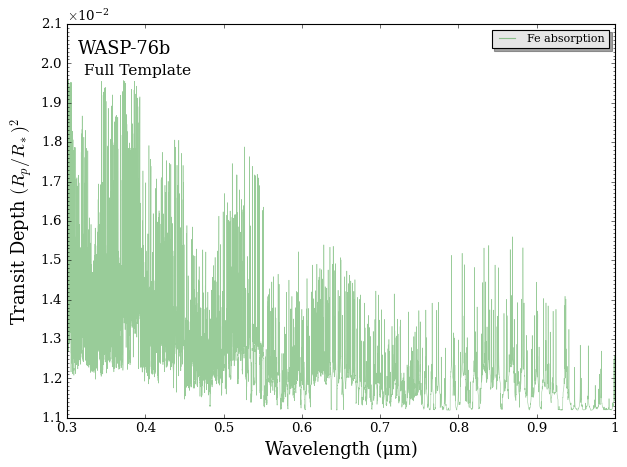

In [6]:
from POSEIDON.utility import plot_collection
from POSEIDON.visuals import plot_spectra

# Add both the high-res spectrum to a new plot collection
spectra = plot_collection(spectrum_high_res, wl_high_res, collection = [])

# Produce figure
fig = plot_spectra(spectra, planet, model, bin_spectra = False,                   # Skip plotting a low resolution binned model 
                   transit_depth_min = 1.1e-2, transit_depth_max = 2.1e-2,
                   spectra_labels = ['Fe absorption'], plt_label = 'Full Template')

We can also zoom in on a narrow wavelength range to see individual $\rm{Fe}$ lines.

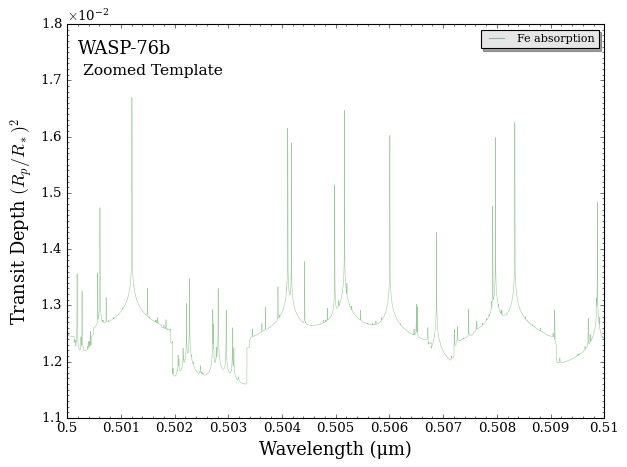

In [7]:
# Produce figure
fig = plot_spectra(spectra, planet, model, bin_spectra = False,
                   wl_min = 0.50, wl_max = 0.51,                                  # 0.50 to 0.51 um
                   transit_depth_min = 1.1e-2, transit_depth_max = 1.8e-2,
                   spectra_labels = ['Fe absorption'], plt_label = 'Zoomed Template')

### Creating a Grid of High-Resolution Spectra

For cross correlation analyses, one will generally desire a grid of template models spanning different chemical species and atmospheric properties.

You can straightforwardly make a grid of high-resolution spectra by constructing a loop over atmospheric properties. The cell below provides an example to build a simple grid of model templates for $\rm{Fe}$ and $\rm{Ca}^{+}$ spanning 3 temperatures and 5 mixing ratios (for a total of 30 models).

<div class="alert alert-info">

  **Note:**

  Running the cell below will take around 30 minutes, with the grid using 2 GB of disk storage.

</div>

In [8]:
from POSEIDON.core import define_model
from POSEIDON.core import make_atmosphere
from POSEIDON.core import wl_grid_line_by_line
from POSEIDON.core import read_opacities
from POSEIDON.core import compute_spectrum
import numpy as np

# Specify arrays of parameters to loop over
T_arr = np.array([2000, 2200, 2400])
log_X_arr = np.array([-8, -7, -6, -5, -4])
template_species = np.array(['Fe', 'Ca+'])

# Define model for grid
bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere

# Specify the pressure grid of the atmosphere
P_min = 1.0e-10   # 0.1 nbar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

#***** Wavelength grid *****#
 
wl_min = 0.3     # Minimum wavelength (um)
wl_max = 1.0     # Maximum wavelength (um)    

wl_high_res = wl_grid_line_by_line(wl_min, wl_max)

#***** Read opacity data *****#

opacity_treatment = 'line_by_line'

model_count = 0   # Counter variable so user can track model grid progress

# Loop over chemical species, temperatures, and mixing ratios
for q in range(len(template_species)):
    for i in range(len(T_arr)):
        for j in range(len(log_X_arr)):

            model_count += 1

            # Load chemical species and atmospheric properties for this template
            param_species = [template_species[q]]
            T_i = T_arr[i]
            log_X_j = log_X_arr[j]

            # Define model name for this parameter combination
            model_name = param_species[0] + '_' + str(log_X_j) + '_T_' + str(T_i) + 'K'

            # Create the model object
            model = define_model(model_name, bulk_species, param_species, 
                                 PT_profile = 'isotherm', cloud_model = 'cloud-free')

            # Prepare high-resolution opacity data
            opac_high_res = read_opacities(model, wl_high_res, opacity_treatment)

            # Store parameters in input array
            PT_params = np.array([T_i])
            log_X_params = np.array([[log_X_j]])

            # Generate the atmosphere
            atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref,
                                         PT_params, log_X_params)

            # Compute the spectrum
            spectrum_high_res = compute_spectrum(planet, star, model, atmosphere, 
                                                 opac_high_res, wl_high_res,
                                                 spectrum_type = 'transmission', 
                                                 save_spectrum = True,
                                                 disable_continuum = True,
                                                 suppress_print = True)             # Suppress 'cross section done' print statements

            print("Model " + str(model_count) + "/" + 
                  str(len(T_arr)*len(log_X_arr)*len(template_species)) + " done.")

Model 1/30 done.
Model 2/30 done.
Model 3/30 done.
Model 4/30 done.
Model 5/30 done.
Model 6/30 done.
Model 7/30 done.
Model 8/30 done.
Model 9/30 done.
Model 10/30 done.
Model 11/30 done.
Model 12/30 done.
Model 13/30 done.
Model 14/30 done.
Model 15/30 done.
Model 16/30 done.
Model 17/30 done.
Model 18/30 done.
Model 19/30 done.
Model 20/30 done.
Model 21/30 done.
Model 22/30 done.
Model 23/30 done.
Model 24/30 done.
Model 25/30 done.
Model 26/30 done.
Model 27/30 done.
Model 28/30 done.
Model 29/30 done.
Model 30/30 done.
